# Load Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# data processing
import pandas as pd
from datetime import datetime
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

# metrics
from sklearn.metrics import mean_squared_error


# Load Data

In [2]:
train_file_path = '/content/sample_data/train_E1GspfA.csv'
test_file_path = '/content/sample_data/test_6QvDdzb.csv'

# load data by parsing date feature
df = pd.read_csv(train_file_path, parse_dates=['date'],infer_datetime_format=True)
test_df = pd.read_csv(test_file_path, parse_dates=['date'],infer_datetime_format=True)

# Basic EDA

In [3]:
### Check data type and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18247 non-null  datetime64[ns]
 1   hour    18247 non-null  int64         
 2   demand  18247 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 427.8 KB


In [4]:
# Traget variable basic statistics
df.demand.describe()

count    18247.000000
mean        73.991451
std         41.678988
min          1.000000
25%         43.000000
50%         71.000000
75%         98.000000
max        379.000000
Name: demand, dtype: float64

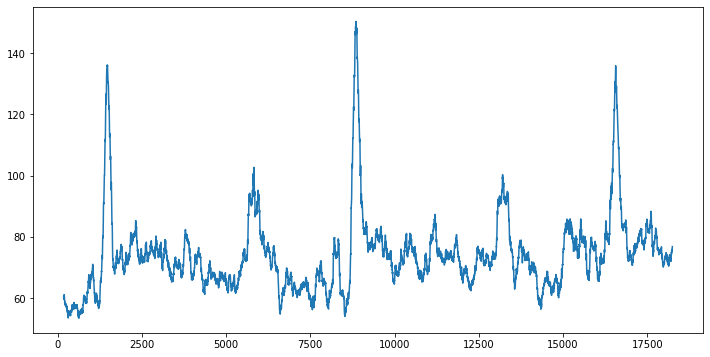

In [ ]:
# Distribution of Target Variable
plt.figure(figsize=(12, 6))
plt.plot(df.demand.rolling(180).mean())

# Train-Validaion split (80:20)

In [9]:
split_ratio = .8
split_index = round(df.shape[0]*split_ratio)
train_df = df[:split_index]
validation_df = df[split_index:]

print('Total df shape :', df.shape)
print('Train df shape :', train_df.shape)
print('Validation df shape :', validation_df.shape)

Total df shape : (18247, 3)
Train df shape : (14598, 3)
Validation df shape : (3649, 3)


# EDA

(725, 1)


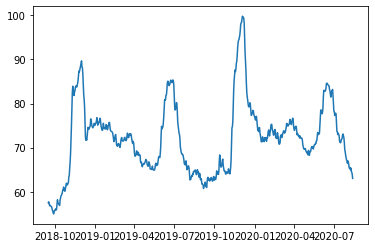

In [ ]:
train_df_by_date = train_df.groupby('date')[['demand']].mean()
print(train_df_by_date.shape)
plt.plot(train_df_by_date['demand'].rolling(30).mean())

(24, 1)


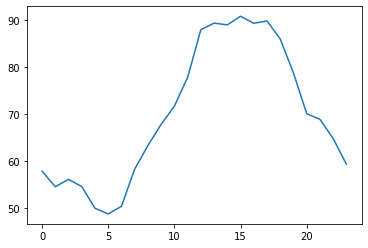

In [ ]:
train_df_by_hour = train_df.groupby('hour')[['demand']].mean()
print(train_df_by_hour.shape)
plt.plot(train_df_by_hour)

(12, 1)


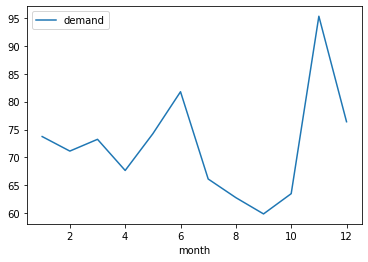

In [ ]:
train_df_by_month = train_df.groupby('month')[['demand']].mean()
print(train_df_by_month.shape)
train_df_by_month.plot()

(7, 1)


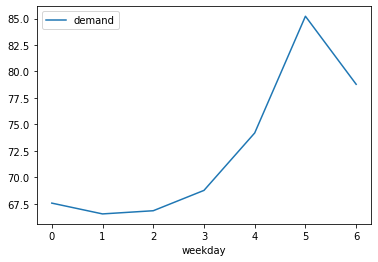

In [ ]:
train_df_by_weekday = train_df.groupby('weekday')[['demand']].mean()
print(train_df_by_weekday.shape)
train_df_by_weekday.plot()

(8033, 4)


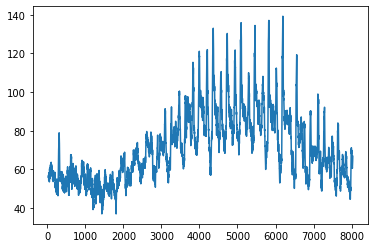

In [ ]:
train_df_by_hour_month_day = train_df.groupby(['hour', 'month', 'day'])['demand'].mean().reset_index()
print(train_df_by_hour_month_day.shape)
train_df_by_hour_month_day['demand'].rolling(30).mean().plot()

# Feature Engineering

In [5]:
def get_date_features(train_data, validation_data):
  # Month
  train_data['month'] = train_data.date.apply(lambda d: d.month)
  validation_data['month'] = validation_data.date.apply(lambda d: d.month)
  
  # Weekday
  train_data['weekday'] = train_data.date.apply(lambda d: d.weekday())
  validation_data['weekday'] = validation_data.date.apply(lambda d: d.weekday())
  
  # Day
  train_data['day'] = train_data.date.apply(lambda d: d.day)
  validation_data['day'] = validation_data.date.apply(lambda d: d.day)

  # IsWeekend
  train_data['IsWeekend'] = train_data.weekday.apply(lambda d: 1 if d in [5,6] else 0)
  validation_data['IsWeekend'] = validation_data.weekday.apply(lambda d: 1 if d in [5,6] else 0)

  return train_data, validation_data


In [6]:
def get_statistical_features(train_data, validation_data):

  # month wise mean
  month_mean_map = {int(month):demand_mean for month, demand_mean in train_data.groupby('month')[['demand']].mean().reset_index().values}
  train_data['month_mean'] = train_data.month.map(month_mean_map)
  validation_data['month_mean'] = validation_data.month.map(month_mean_map)
  
  # weekday wise mean
  weekday_mean_map = {int(weekday):demand_mean for weekday, demand_mean in train_data.groupby('weekday')[['demand']].mean().reset_index().values}
  train_data['weekday_mean'] = train_data.weekday.map(weekday_mean_map)
  validation_data['weekday_mean'] = validation_data.weekday.map(weekday_mean_map)
  
  # hourly mean
  hourly_mean_map = {int(hour):demand_mean for hour, demand_mean in train_data.groupby('hour')[['demand']].mean().reset_index().values}
  train_data['hourly_mean'] = train_data.hour.map(hourly_mean_map)
  validation_data['hourly_mean'] = validation_data.hour.map(hourly_mean_map)

  # month wise min
  month_min_map = {int(month):demand_min for month, demand_min in train_data.groupby('month')[['demand']].min().reset_index().values}
  train_data['month_min'] = train_data.month.map(month_min_map)
  validation_data['month_min'] = validation_data.month.map(month_min_map)
  
  # weekday wise min
  weekday_min_map = {int(weekday):demand_min for weekday, demand_min in train_data.groupby('weekday')[['demand']].min().reset_index().values}
  train_data['weekday_min'] = train_data.weekday.map(weekday_min_map)
  validation_data['weekday_min'] = validation_data.weekday.map(weekday_min_map)
  
  # hourly min
  hourly_min_map = {int(hour):demand_min for hour, demand_min in train_data.groupby('hour')[['demand']].min().reset_index().values}
  train_data['hourly_min'] = train_data.hour.map(hourly_min_map)
  validation_data['hourly_min'] = validation_data.hour.map(hourly_min_map)

  # month wise max
  month_max_map = {int(month):demand_max for month, demand_max in train_data.groupby('month')[['demand']].max().reset_index().values}
  train_data['month_max'] = train_data.month.map(month_max_map)
  validation_data['month_max'] = validation_data.month.map(month_max_map)
  
  # weekday wise max
  weekday_max_map = {int(weekday):demand_max for weekday, demand_max in train_data.groupby('weekday')[['demand']].max().reset_index().values}
  train_data['weekday_max'] = train_data.weekday.map(weekday_max_map)
  validation_data['weekday_max'] = validation_data.weekday.map(weekday_max_map)
  
  # hourly max
  hourly_max_map = {int(hour):demand_max for hour, demand_max in train_data.groupby('hour')[['demand']].max().reset_index().values}
  train_data['hourly_max'] = train_data.hour.map(hourly_max_map)
  validation_data['hourly_max'] = validation_data.hour.map(hourly_max_map)

  return train_data, validation_data
  

In [10]:
# extraction of features
train_df, validation_df = get_date_features(train_df, validation_df)
train_df, validation_df = get_statistical_features(train_df, validation_df)

In [11]:
print('After Feature Extraction :',train_df.shape)
train_df.head()

After Feature Extraction : (14598, 16)


,date,hour,demand,month,weekday,day,IsWeekend,month_mean,weekday_mean,hourly_mean,month_min,weekday_min,hourly_min,month_max,weekday_max,hourly_max
0,2018-08-18,9,91,8,5,18,1,62.810599,85.219729,67.789548,2,1,5,147,379,200
1,2018-08-18,10,21,8,5,18,1,62.810599,85.219729,71.651261,2,1,5,147,379,232
2,2018-08-18,13,23,8,5,18,1,62.810599,85.219729,89.341226,2,1,5,147,379,321
3,2018-08-18,14,104,8,5,18,1,62.810599,85.219729,88.967832,2,1,6,147,379,289
4,2018-08-18,15,81,8,5,18,1,62.810599,85.219729,90.808067,2,1,2,147,379,366


In [12]:
print('After Feature Extraction :',validation_df.shape)
validation_df.head()

After Feature Extraction : (3649, 16)


,date,hour,demand,month,weekday,day,IsWeekend,month_mean,weekday_mean,hourly_mean,month_min,weekday_min,hourly_min,month_max,weekday_max,hourly_max
14598,2020-08-12,7,52,8,2,12,0,62.810599,66.834232,58.252322,2,2,2,147,313,119
14599,2020-08-12,8,90,8,2,12,0,62.810599,66.834232,63.270000,2,2,2,147,313,139
14600,2020-08-12,9,34,8,2,12,0,62.810599,66.834232,67.789548,2,2,5,147,313,200
14601,2020-08-12,10,76,8,2,12,0,62.810599,66.834232,71.651261,2,2,5,147,313,232
14602,2020-08-12,11,46,8,2,12,0,62.810599,66.834232,77.767181,2,2,2,147,313,224


# Modelling

## Data Preparation

In [13]:
X_train, y_train = train_df.drop(['date','demand'],axis=1), train_df.demand
print(X_train.shape, y_train.shape)

X_valid, y_valid = validation_df.drop(['date','demand'],axis=1), validation_df.demand
print(X_valid.shape, y_valid.shape)


(14598, 14) (14598,)
(3649, 14) (3649,)


## NaN check

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14598 entries, 0 to 14597
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour          14598 non-null  int64  
 1   month         14598 non-null  int64  
 2   weekday       14598 non-null  int64  
 3   day           14598 non-null  int64  
 4   IsWeekend     14598 non-null  int64  
 5   month_mean    14598 non-null  float64
 6   weekday_mean  14598 non-null  float64
 7   hourly_mean   14598 non-null  float64
 8   month_min     14598 non-null  int64  
 9   weekday_min   14598 non-null  int64  
 10  hourly_min    14598 non-null  int64  
 11  month_max     14598 non-null  int64  
 12  weekday_max   14598 non-null  int64  
 13  hourly_max    14598 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 1.6 MB


In [ ]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 14598 to 18246
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour          3649 non-null   int64  
 1   month         3649 non-null   int64  
 2   weekday       3649 non-null   int64  
 3   day           3649 non-null   int64  
 4   IsWeekend     3649 non-null   int64  
 5   month_mean    3649 non-null   float64
 6   weekday_mean  3649 non-null   float64
 7   hourly_mean   3649 non-null   float64
 8   month_min     3649 non-null   int64  
 9   weekday_min   3649 non-null   int64  
 10  hourly_min    3649 non-null   int64  
 11  month_max     3649 non-null   int64  
 12  weekday_max   3649 non-null   int64  
 13  hourly_max    3649 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 399.2 KB


## Utils

In [14]:
# plot feature importance

def feature_importance_plot(model, x_train, top=10):
  features = x_train.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)[:top]

  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()

In [15]:
# model_training
def model_training(model, x_train, y_train, x_valid, y_valid=pd.DataFrame(), predict_valid_data=True, plot_feature_importance=False):
    
  # Fitting the model
  model.fit(x_train, y_train)

  # Predict the model
  train_pred = model.predict(x_train)
  valid_pred = model.predict(x_valid)
    
  # RMSE Computation
  train_rmse = mean_squared_error(y_train, train_pred, squared=False)
  print("Train RMSE : % f" %(train_rmse))

  if predict_valid_data:
    valid_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
    print("Validation RMSE : % f" %(valid_rmse))

    models_training_data['train_rmse'].append(train_rmse)
    models_training_data['valid_rmse'].append(valid_rmse)

  if plot_feature_importance:
    feature_importance_plot(model, x_train)

  return model, train_pred, valid_pred


## Try ALL Models

In [16]:
models_training_data = {'model':[], 'train_rmse':[], 'valid_rmse':[]}

### Linear Regression


In [17]:
# Linear Regression
models_training_data['model'].append('Linear Regression')
lr_reg, lr_reg_train_pred, lr_reg_valid_pred = model_training(LinearRegression(), X_train, y_train, X_valid, y_valid)

Train RMSE :  36.345533
Validation RMSE :  40.195853


### SupportVector Regression


In [18]:
# SupportVector Regression
models_training_data['model'].append('SupportVector Regression')
sv_reg, sv_reg_train_pred, sv_reg_valid_pred = model_training(SVR(), X_train, y_train, X_valid, y_valid)

Train RMSE :  37.351938
Validation RMSE :  41.169265


### DecisionTree Regression


In [19]:
# DecisionTree Regression
models_training_data['model'].append('DecisionTree Regression')
dt_reg, dt_reg_train_pred, dt_reg_valid_pred = model_training(DecisionTreeRegressor(max_depth=2), X_train, y_train, X_valid, y_valid)

Train RMSE :  37.542829
Validation RMSE :  40.664987


### RandomForest Regression

Train RMSE :  32.118604
Validation RMSE :  37.956830


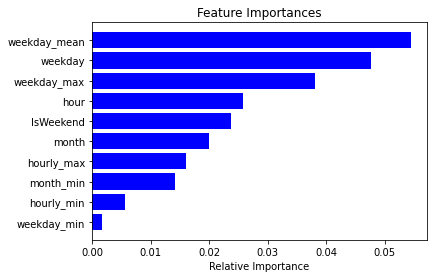

In [20]:
# RandomForest Regression
models_training_data['model'].append('RandomForest Regression')
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=7, random_state=0)

rf_reg, rf_reg_train_pred, rf_reg_valid_pred = model_training(rf_reg, X_train, y_train, X_valid, y_valid, plot_feature_importance=True)

### XGBoost Regression - Hyperparameter Tuning

In [21]:
xgb_tune = xg.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, 
                           gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:squarederror',
                           nthread=4, scale_pos_weight=1, seed=123)

xgb_param = xgb_tune.get_xgb_params()
xgtrain = xg.DMatrix(X_train.values, label=y_train.values)
cvresult = xg.cv(xgb_param, xgtrain, num_boost_round=xgb_tune.get_params()['n_estimators'], nfold=5,
            metrics='rmse', early_stopping_rounds=50)
xgb_tune.set_params(n_estimators=cvresult.shape[0])


XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=172, nthread=4,
             objective='reg:squarederror', seed=123, subsample=0.8)

In [22]:
#Fit the algorithm on the data
xgb_tune.fit(X_train, y_train, eval_metric='rmse')
        
train_pred = xgb_tune.predict(X_train)
valid_pred = xgb_tune.predict(X_valid)
    
# RMSE Computation
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print("Train RMSE : % f" %(train_rmse))
valid_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
print("Valid RMSE : % f" %(valid_rmse))


Train RMSE :  29.865762
Valid RMSE :  38.132610


Train RMSE :  29.865762
Validation RMSE :  38.132610


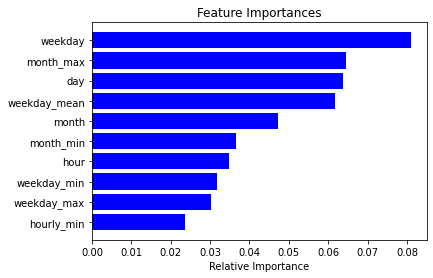

In [23]:
# XGBoost Regression
models_training_data['model'].append('XGBoost Regression')
xgb_reg = xg.XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=172, nthread=4,
             objective='reg:squarederror', seed=123, subsample=0.8)

xgb_reg, xgb_reg_train_pred, xgb_reg_valid_pred = model_training(xgb_reg, X_train, y_train, X_valid, y_valid, plot_feature_importance=True)

## Model Comparision

In [24]:
pd.DataFrame(models_training_data).sort_values(['train_rmse', 'valid_rmse'])

,model,train_rmse,valid_rmse
4,XGBoost Regression,29.865762,38.132610
3,RandomForest Regression,32.118604,37.956830
0,Linear Regression,36.345533,40.195853
1,SupportVector Regression,37.351938,41.169265
2,DecisionTree Regression,37.542829,40.664987


# Submission

## Data Preparaion

In [25]:
# extraction of features
df, test_df = get_date_features(df, test_df)
df, test = get_statistical_features(df, test_df)

In [26]:
# data preparation
X, y = df.drop(['date','demand'],axis=1), df.demand
print(X.shape, y.shape)

X_test = test_df.drop(['date'],axis=1)
print(X_test.shape)


(18247, 14) (18247,)
(7650, 14)


## Final Model Training

### XGBoost Regression - Submission
    LeaderBorad Score - 33.3522051148776

In [27]:
final_model = xg.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, 
                           gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:squarederror',
                           nthread=4, scale_pos_weight=1, seed=123)

xgb_param = final_model.get_xgb_params()
xgtrain = xg.DMatrix(X.values, label=y.values)
cvresult = xg.cv(xgb_param, xgtrain, num_boost_round=final_model.get_params()['n_estimators'], nfold=5,
            metrics='rmse', early_stopping_rounds=50)
final_model.set_params(n_estimators=cvresult.shape[0])


XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=142, nthread=4,
             objective='reg:squarederror', seed=123, subsample=0.8)

In [28]:
#Fit the algorithm on the data
final_model.fit(X, y, eval_metric='rmse')
        
train_pred = final_model.predict(X)
    
# RMSE Computation
train_rmse = mean_squared_error(y, train_pred, squared=False)
print("Train RMSE : % f" %(train_rmse))


Train RMSE :  31.382865


Train RMSE :  30.611248


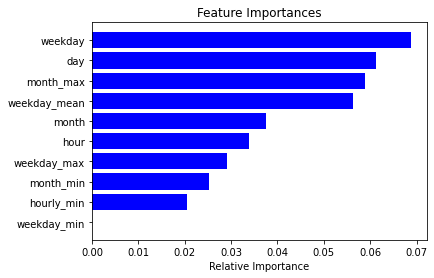

In [30]:
# XGBoost Regression
final_model = xg.XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=224, nthread=4,
             objective='reg:squarederror', seed=123, subsample=0.8)
final_model, _, test_df['demand'] = model_training(final_model, X, y, X_test, predict_valid_data=False, plot_feature_importance=True)

In [31]:
#### Export CSV File
description = 'xgb_tuning_with_bare_plus_basic_statistical_features'
submission_date = '24_April'
version_number = 'v2'
csv_file_name = f'{description}_{submission_date}_{version_number}.csv'
required_features = ['date', 'hour', 'demand']

test_df['demand'] = final_model.predict(X_test)
test_df[required_features].to_csv(csv_file_name, index=False)